<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подключение-библиотек" data-toc-modified-id="Подключение-библиотек-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Подключение библиотек</a></span></li></ul></li><li><span><a href="#Знакомство-с-данными-и-агрегация" data-toc-modified-id="Знакомство-с-данными-и-агрегация-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Знакомство с данными и агрегация</a></span><ul class="toc-item"><li><span><a href="#Обзор" data-toc-modified-id="Обзор-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор</a></span></li><li><span><a href="#Фильтрация" data-toc-modified-id="Фильтрация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Фильтрация</a></span></li><li><span><a href="#Агрегация" data-toc-modified-id="Агрегация-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Агрегация</a></span></li><li><span><a href="#Такси-Empire-State-Building" data-toc-modified-id="Такси-Empire-State-Building-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Такси Empire State Building</a></span></li><li><span><a href="#Число-пар-час-ячейка-в-мае-2016,-для-которых-не-было-совершено-ни-одной-поездки" data-toc-modified-id="Число-пар-час-ячейка-в-мае-2016,-для-которых-не-было-совершено-ни-одной-поездки-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Число пар час-ячейка в мае 2016, для которых не было совершено ни одной поездки</a></span></li><li><span><a href="#Сохренени-агрегированных-данных" data-toc-modified-id="Сохренени-агрегированных-данных-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Сохренени агрегированных данных</a></span></li></ul></li></ul></div>

## Подключение библиотек

In [1]:
import requests
from os import path
from IPython.lib import backgroundjobs as bg

import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import binned_statistic_2d

import seaborn as sn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


E:\Users\alex\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# https://habr.com/ru/post/276725/
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
def download_data(from_url, to_file):
    r = requests.get(from_url, stream=True)
    with open(to_file, 'wb') as f:
        total_length = int(r.headers.get('content-length'))
        for chunk in log_progress(r.iter_content(chunk_size=1024), every=100, size=int(total_length/1024) + 1):
            if chunk:
                f.write(chunk)
                f.flush()

In [4]:
def get_url(year, month):
    return "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{}-{:02d}.csv".format(year, month)

In [5]:
def get_data_file_name(year, month):
    return "{}-{:02d}.csv".format(year, month)

In [17]:
download_data(get_url(2016, 5), get_data_file_name(2016, 5))

In [545]:
jobs = bg.BackgroundJobManager()

In [546]:
for year in range(2013,2016):
    for month in range(1,13):
        jobs.new(download_data, get_url(year, month), path.join('data', get_data_file_name(year, month)))

In [6]:
for year in range(2016,2020):
    for month in range(1,13):
        jobs.new(download_data, get_url(year, month), path.join('data', get_data_file_name(year, month)))

# Знакомство с данными и агрегация

In [6]:
d_2016_05 = pd.read_csv('2016-05.csv')

columns                   | description
--------------------------|-------------
**VendorID**              | vendor (int)
**tpep_pickup_datetime**  | pick-up dates/times (datetime)
**tpep_dropoff_datetime** | drop-off dates/times (datetime)
**passenger_count**       | passenger counts (int)
**trip_distance**         | trip distances (float, km/m?)
**pickup_longitude**      | pickup longitudes (float, °)
**pickup_latitude**       | pickup latitude (float, °)
**RatecodeID**            | rate code (int)
**store_and_fwd_flag**    | store and fwd flag (str, N/Y)
**dropoff_longitude**     | dropoff longitude (float, °)
**dropoff_latitude**      | dropoff latitude (float, °)
**payment_type**          | payment type (int)
**fare_amount**           | fare amount (float, \$)
**extra**                 | extra (float, \$)
**mta_tax**               | Metropolitan Transit Authority tax (float, \$)
**tip_amount**            | tip amount (float, \$)
**tolls_amount**          | tolls amount (float, \$)
**improvement_surcharge** | improvement surcharge (float, \$)
**total_amount**          | total amount (float, \$)

In [7]:
d_2016_05["tpep_pickup_datetime"] = pd.to_datetime(d_2016_05.tpep_pickup_datetime)
d_2016_05["tpep_dropoff_datetime"] = pd.to_datetime(d_2016_05.tpep_dropoff_datetime)

## Обзор

In [8]:
d_2016_05.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [9]:
d_2016_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   pickup_longitude       float64       
 6   pickup_latitude        float64       
 7   RatecodeID             int64         
 8   store_and_fwd_flag     object        
 9   dropoff_longitude      float64       
 10  dropoff_latitude       float64       
 11  payment_type           int64         
 12  fare_amount            float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  tip_amount             float64       
 16  tolls_amount           float64       
 17  improvement_surcharge  float64       
 18  total_amount        

In [10]:
d_2016_05.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07
mean,1.529075e+00,1.662265e+00,6.110069e+00,-7.304978e+01,4.024234e+01,1.045014e+00,-7.311869e+01,4.028127e+01,1.349840e+00,1.334066e+01,3.291893e-01,4.972577e-01,1.831982e+00,3.422044e-01,2.996838e-01,1.664095e+01
std,4.991539e-01,1.304418e+00,5.155162e+03,8.212003e+00,4.523904e+00,6.203209e-01,7.902544e+00,4.353644e+00,4.942504e-01,1.188799e+01,4.585669e-01,4.473578e-02,2.665043e+00,1.760303e+00,1.300760e-02,1.450379e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.650819e+02,-4.456935e+01,1.000000e+00,-1.295732e+02,0.000000e+00,1.000000e+00,-4.100000e+02,-3.900000e+01,-2.700000e+00,-8.000000e+01,-1.500000e+01,-3.000000e-01,-4.103000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399179e+01,4.073611e+01,1.000000e+00,-7.399116e+01,4.073457e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,2.000000e+00,1.000000e+00,1.720000e+00,-7.398136e+01,4.075375e+01,1.000000e+00,-7.397922e+01,4.075439e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.260000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,2.000000e+00,3.270000e+00,-7.396588e+01,4.076862e+01,1.000000e+00,-7.396164e+01,4.077012e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.836000e+01
max,2.000000e+00,9.000000e+00,1.200000e+07,1.184089e+02,5.366724e+01,9.900000e+01,0.000000e+00,7.012994e+01,5.000000e+00,8.007000e+03,7.900000e+01,4.030000e+01,7.500000e+02,1.120680e+03,3.100000e+00,8.007800e+03


In [11]:
d_2016_05.store_and_fwd_flag.value_counts()

N    11773155
Y       63698
Name: store_and_fwd_flag, dtype: int64

In [12]:
d_2016_05.isna().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
pickup_longitude         False
pickup_latitude          False
RatecodeID               False
store_and_fwd_flag       False
dropoff_longitude        False
dropoff_latitude         False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
dtype: bool

## Фильтрация

Видим, что есть отрицательные значения для некоторых долларовых столбцов (строка min). Не очень понятно, нормально это или нет. Избавимся от записей с числом пассажиров, длительностью поездки и расстоянием по счетчику, равными 0.

In [13]:
d_2016_05.shape

(11836853, 19)

In [14]:
duration = d_2016_05.tpep_dropoff_datetime - d_2016_05.tpep_pickup_datetime

In [15]:
print("Число поездок с нулевой длительностью: ", (duration == datetime.timedelta(seconds=0)).sum())
print("Число поездок с отрицательной длительностью: ", (duration < datetime.timedelta(seconds=0)).sum())

Число поездок с нулевой длительностью:  12268
Число поездок с отрицательной длительностью:  59


In [16]:
d_2016_05 = d_2016_05[duration > datetime.timedelta(seconds=0)]
d_2016_05.shape

(11824526, 19)

In [17]:
print("Число поездок без пассажиров: ", (d_2016_05.passenger_count==0).sum())

Число поездок без пассажиров:  522


In [18]:
d_2016_05 = d_2016_05[d_2016_05.passenger_count!=0]
d_2016_05.shape

(11824004, 19)

In [19]:
print("Число поездок с нулевым расстоянием: ", (d_2016_05.trip_distance==0).sum())

Число поездок с нулевым расстоянием:  60638


In [20]:
d_2016_05 = d_2016_05[d_2016_05.trip_distance!=0]
d_2016_05.shape

(11763366, 19)

Отбрасываем минуты и секунды

In [21]:
d_2016_05["tpep_pickup_datetime"] = d_2016_05.tpep_pickup_datetime.dt.floor('H')

Отбросим поездки, начавшиеся за пределами прямоугольника Нью-Йорка

In [22]:
out_of_bound = ((d_2016_05.pickup_longitude < -74.25559) | (d_2016_05.pickup_longitude > -73.70001) | 
 (d_2016_05.pickup_latitude < 40.49612) | (d_2016_05.pickup_latitude > 40.91553)).sum()
print("Число поездок, начавшихся за пределами прямоугольника Нью-Йорка:", out_of_bound)

Число поездок, начавшихся за пределами прямоугольника Нью-Йорка: 136845


In [23]:
inbound = ((d_2016_05.pickup_longitude >= -74.25559) & (d_2016_05.pickup_longitude <= -73.70001) & 
 (d_2016_05.pickup_latitude >= 40.49612) & (d_2016_05.pickup_latitude <= 40.91553))
d_2016_05 = d_2016_05[inbound]

## Агрегация

In [24]:
regions = pd.read_csv('regions.csv', ';')

Границы для binned_statistic_2d

In [25]:
x_edge = regions.west.unique()
x_edge = np.append(x_edge, regions.east.max())
y_edge = regions.south.unique()
y_edge = np.append(y_edge, regions.north.max())

Границы прямоугольника Нью-Йорка

In [26]:
xmin = regions.west.min()
xmax = regions.east.max()
ymin = regions.south.min()
ymax = regions.north.max()
xmin, xmax, ymin, ymax

(-74.25559, -73.70000999999999, 40.49612, 40.91553)

In [27]:
count_by_region = binned_statistic_2d(d_2016_05.pickup_longitude.values, d_2016_05.pickup_latitude.values,
                   np.ones(d_2016_05.shape[0]), 'count', bins=[x_edge, y_edge]).statistic

Задав границы отрезка (xmin, xmax), число разбиений (bins), функция get_bin_ind возвращает в какое разбиение попадает x (x - DataFrame)

In [28]:
def get_bin_ind(x, xmin, xmax, bins):
    return ((x - xmin) / ((xmax - xmin)/bins)).values.astype(int)

Аналогично для двумерного разбиения

In [29]:
def get_bin(x, y, xmin, xmax, ymin, ymax, xbins, ybins):
    return get_bin_ind(x, xmin, xmax, xbins)*xbins + get_bin_ind(y, ymin, ymax, ybins)

Аналогичные функции, но x - одно число

In [30]:
def get_bin_ind_s(x, xmin, xmax, bins):
    return int(((x - xmin) / ((xmax - xmin)/bins)))

In [31]:
def get_bin_s(x, y, xmin, xmax, ymin, ymax, xbins, ybins):
    return get_bin_ind_s(x, xmin, xmax, xbins)*xbins + get_bin_ind_s(y, ymin, ymax, ybins)

Получаем номера регионов для каждой поездки

In [32]:
region = get_bin(d_2016_05.pickup_longitude, d_2016_05.pickup_latitude, xmin, xmax, ymin, ymax, 50, 50) + 1

In [33]:
d_2016_05['region'] = region

Агрегируем по региону и по времени, получаем столбец с чилом поездок для каждой пары регион-время (с пропусками)

In [34]:
counts = d_2016_05.groupby(['region', 'tpep_pickup_datetime']).count()['VendorID']
counts.name = 'count'

In [35]:
counts.head()

region  tpep_pickup_datetime
15      2016-05-20 13:00:00     1
16      2016-05-23 08:00:00     1
25      2016-05-04 13:00:00     1
27      2016-05-30 03:00:00     1
32      2016-05-01 17:00:00     1
Name: count, dtype: int64

Приводим таблицу к виду index=время, columns=регион, values=число поездок для пары регион-время

In [36]:
counts_u = counts.unstack(level=0, fill_value=0)

In [37]:
counts_u.head()

region,15,16,25,27,32,45,49,61,77,80,...,2476,2478,2479,2481,2482,2483,2484,2485,2486,2487
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Видим, что регионы отображаются не все. Возможно то же самое со временем. Восполним недостающие столбцы/строки

In [38]:
new_index = pd.date_range(datetime.datetime(year=2016, month=5, day=1), datetime.datetime(year=2016, month=5, day=31, hour=23), freq='H')
new_columns = range(1,2501)

In [39]:
counts_full = counts_u.reindex(index=new_index, columns=new_columns).fillna(0).astype(int)

In [40]:
counts_full.head()

region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Такси Empire State Building

Получим номер региона Empire State Building

Координаты Empire State Building: (-73.985352, 40.748418)

In [41]:
esb_region = get_bin_s(-73.985352, 40.748418, xmin, xmax, ymin, ymax, 50, 50) + 1
esb_region

1231

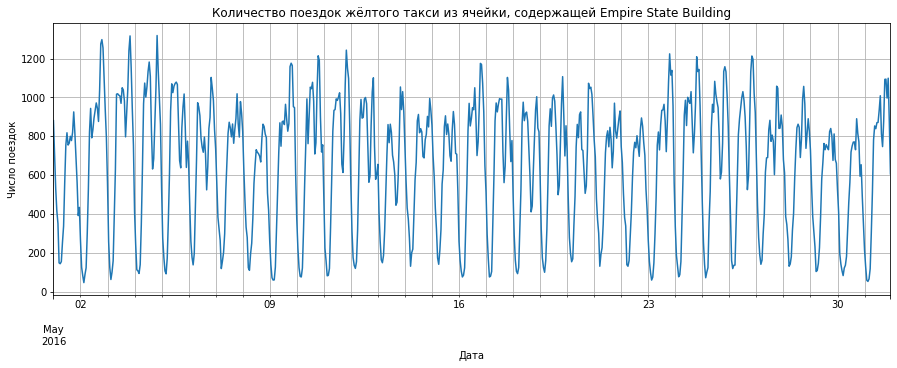

In [42]:
pylab.figure(figsize=(15,5))
counts_full[esb_region].plot()
pylab.xlabel("Дата")
pylab.ylabel("Число поездок")
pylab.title("Количество поездок жёлтого такси из ячейки, содержащей Empire State Building")
pylab.grid(which='both')

## Число пар час-ячейка в мае 2016, для которых не было совершено ни одной поездки

In [43]:
print("Число пар час-ячейка в мае 2016, для которых не было совершено ни одной поездки", (counts_full == 0).sum().sum())

Число пар час-ячейка в мае 2016, для которых не было совершено ни одной поездки 1718238


## Сохренени агрегированных данных

In [45]:
counts_full.to_csv("2016-05-ct.csv")